<a href="https://colab.research.google.com/github/oraziotorre/TTinsight/blob/main/TTinsight_DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TTinsight


---


## Data Preprocessing, Feature Engineering e Model Development

In questo notebook vedremo tutto il processo per il caricamento, l'analisi e la pulizia dei dati. Sceglieremo poi le feature migliori e addestreremo un classificatore binario.

Vogliamo addrestrare un modello che predica la probabilità di "W" nella colonna matcht result

# **Inizializzazione**

In [41]:
# Importazioni necessarie per il lavoro con i dati e il machine learning

# Pandas per la gestione dei dati
import pandas as pd
import numpy as np
from collections import Counter
import ast
import math
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import concatenate
import seaborn as sns
import matplotlib.pyplot as plt

# Per la preparazione e la divisione dei dati
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import seaborn as sns

#Per il k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


# Keras per il preprocessing delle sequenze
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# Deep Learning con TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Masking, Embedding, Dropout

# Per visualizzare i DataFrame su Google Colab in formato tabellare
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [42]:
dataset = pd.read_csv("raw_dataset.csv")

dataset

,event_id,match_id,match_format,players_gender,match_stage,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ..."
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,0-0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ..."
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-1,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ..."
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,1-0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ..."
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,1-1,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,1-1,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ..."
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,1-2,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ..."
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,2-1,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ..."
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,2-2,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]"


# **Etichettatura**

Il dataset avrà una nuova colonna ```set_result``` che conterrà il risultato del set per ogni partita:

- **1** per la classe **Vincitori** del set
- **0** per la classe **Sconfitti** del set

Questo tipo di etichettatura è utile per i nostri LSTM e Regressione Logistica, dove l'obiettivo sarà quello di prevedere se un giocatore vincerà o perderà un set sulla base di altre informazioni.


In [43]:
# Funzione per convertire i punteggi da stringa a lista di interi
def convert_to_int_list(points_str):
    # Verifica che la stringa sia valida
    if isinstance(points_str, str):
        # Rimuove le parentesi quadre e suddivide la stringa per ottenere i numeri
        return list(map(int, points_str.strip('[]').split(', ')))
    else:
        return None


# Funzione per determinare il risultato del set
def calculate_set_result(player_points, opponent_points):
    if player_points:
        if player_points[-1] > opponent_points[-1]:
            return 1  # Vittoria per il giocatore
        else:
            return 0  # Sconfitta per il giocatore
    else:
        return -1  # Dati non conformi

# Inizializzo una lista vuota per la nuova colonna con le etichette
set_results = []

# Trasformo i punteggi in liste di interi utilizzando la funzione definita
dataset['player_points'] = dataset['player_points'].apply(convert_to_int_list)
dataset['opponent_points'] = dataset['opponent_points'].apply(convert_to_int_list)

# Itero su ogni riga e dai punteggi definisce l'etichetta
for index, row in dataset.iterrows():
    result = calculate_set_result(row['player_points'], row['opponent_points'])
    set_results.append(result)

# Aggiungo la nuova colonna 'set_result' al DataFrame
dataset['set_result'] = set_results

# Visualizzo il risultato
dataset




,event_id,match_id,match_format,players_gender,match_stage,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points,set_result
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,0-0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-1,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,1-0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,1-1,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,1-1,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,1-2,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,2-1,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,2-2,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


# **Analisi dei dati**


## Controllo del bilanciamento dei dati
Una delle prime cose che possiamo verificare è se il dataset sia **bilanciato**. Per cui, controlliamo il numero di istanze **1** e **0** della colonna *set_result*

In [44]:
# Numero di elementi per la classe "Vincitori"
print(len(dataset[(dataset['set_result'] == 1)]))
# Numero di elementi per la classe "Sconfitti"
print(len(dataset[(dataset['set_result'] == 0)]))

# Totale
print(len(dataset))


69607
69607
144194


Notiamo che abbiamo un dataset non troppo sbilanciato

## **Analisi delle caratteristiche e delle distribuzioni dei dati**
Usiamo `describe()` per avere una overview sulle distribuzioni dei dati numerici

In [45]:
# Verifico la correttezza dei campi numerici
dataset.describe()

,event_id,stage_id,match_duration,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,sets_required_to_win,set_result
count,144194.000000,144194.000000,144194.000000,144194.000000,35116.000000,144194.000000,35116.000000,144194.000000,144194.000000,144194.000000,144194.000000
mean,2702.487149,1556.146095,2058.918221,123836.818280,125800.822332,123836.818280,125800.822332,2.086800,2.086800,3.146705,0.448195
std,156.933844,5453.961129,1575.253127,17169.115984,17804.203785,17169.115984,17804.203785,1.250522,1.250522,0.353970,0.562487
min,2234.000000,100.000000,0.000000,90051.000000,100001.000000,90051.000000,100001.000000,0.000000,0.000000,2.000000,-1.000000
25%,2569.000000,200.000000,1426.000000,114715.000000,115565.000000,114715.000000,115565.000000,1.000000,1.000000,3.000000,0.000000
50%,2701.000000,600.000000,1914.000000,121403.000000,122428.000000,121403.000000,122428.000000,3.000000,3.000000,3.000000,0.000000
75%,2869.000000,1200.000000,2430.000000,132081.000000,133124.000000,132081.000000,133124.000000,3.000000,3.000000,3.000000,1.000000
max,2997.000000,110005.000000,77074.000000,212088.000000,212090.000000,212088.000000,212090.000000,5.000000,5.000000,5.000000,1.000000


Notiamo che nella colonna "set_required_to_win" sono presenti dei valori rari non nel nostro interesse (2 e 5)

## **Controllo dei valori nulli**

Verifico i valori mancanti nei dati

In [46]:
# Identificare i valori NaN nel dataset
nan_mask = dataset.isna()

# Conta i valori NaN (valori mancanti) per ciascuna colonna del dataset
nan_count = nan_mask.sum()

# Verifico i valori null del raw_dataset
nan_count


,0
event_id,0
match_id,0
match_format,0
players_gender,0
match_stage,0
stage_id,0
match_duration,0
match_start_time,0
player_id,0
player_2_id,109078


#**Operazione sulle feature**


Facciamo alcune considerazioni sulle caratteristiche del nostro dataset e identifichiamo possibili **miglioramenti** per ottimizzarlo in vista del prossimo training del modello:

* Possibile **trasformare i formati T** nella colonna ```match_format``` in formati che siano o S o D

* La colonna ```match_stage``` può essere modificata per attribuire **maggiore importanza alle partite finali** (FNL) rispetto a tutte le altre, migliorando il peso di queste informazioni nel training del modello.

* Le colonne ```sets_required_to_win``` e ```current_match_state``` fanno entrambe riferimento al numero di set necessari per vincere una partita. Per rendere il dataset più chiaro e organizzato, possiamo **sostituirle** con due nuove colonne: ```sets_to_win``` e ```opponent_sets_to_win```, che rappresentano rispettivamente il numero di set necessari al giocatore e all'avversario per vincere la partita.

* Per la colonna ```players_gender``` si può semplificare il formato tramite l'operazione di ***One-Hot Encoding*** nel caso di dataset_all_matches o tramite una semplice codifica binaria nel caso del dataset_single_matches

*  Le colonne ```match_format```, ```player_id```, ```player_2_id``` **non sono necessarie** per il training del modello e possono essere cancellate




## **Colonna *match_format***

Modifica la colonna *match_format*, sostituendo tutti i valori ' T ' (partita di team) con ' S ' (partita di singolo) o ' D ' (partita di doppio)

Viene eseguita questa operazione per **evitare la rimozione di valori** che potrebbero ritornarci utile successivamente nello sviluppo del nostro modello

In [47]:
# Funzione per determinare il match_format quando è Team (Singolo o Doppio)
def determine_match_format(player_2_id):
    # Controlla se il valore di player_2_id è NaN (valore mancante)
    if pd.isna(player_2_id):
        return 'S'  # Ritorna 'S' per indicare una partita singola
    else:
        return 'D'  # Ritorna 'D' per indicare una partita doppia

# Applica la funzione determine_match_format alla colonna 'player_2_id' del dataset
# Modificando il valore nella colonna match_format di tipo S o D
dataset['match_format'] = dataset['player_2_id'].apply(determine_match_format)

# Mostra il dataset aggiornato
dataset


,event_id,match_id,match_format,players_gender,match_stage,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points,set_result
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,0-0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-1,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,1-0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,FNL,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,1-1,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,1-1,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,1-2,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,2-1,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,RND2,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,2-2,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


In base a ciò che abbiamo appreso precedentemente da `describe()`, rimuoviamo i valori non desiderati della colonna *sets_required_to_win* uguali a 2 o 5.

Questi valori rari potrebbero rappresentare **formati di gioco non standard** (es. partite amichevoli o partite abbreviate per motivi eccezionali), non rilevanti per l'analisi



In [48]:
# Rimuoviamo le righe contenenti set con punteggi rari che non vogliamo considerare
dataset = dataset[~dataset['sets_required_to_win'].isin([2, 5])]

dataset.describe()

,event_id,stage_id,match_duration,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,sets_required_to_win,set_result
count,144186.000000,144186.000000,144186.000000,144186.000000,35116.000000,144186.000000,35116.000000,144186.000000,144186.000000,144186.000000,144186.000000
mean,2702.497746,1556.146436,2058.904013,123837.064202,125800.822332,123837.064202,125800.822332,2.086791,2.086791,3.146686,0.448213
std,156.931733,5454.110892,1575.282189,17169.454336,17804.203785,17169.454336,17804.203785,1.250485,1.250485,0.353793,0.562468
min,2234.000000,100.000000,0.000000,90051.000000,100001.000000,90051.000000,100001.000000,0.000000,0.000000,3.000000,-1.000000
25%,2569.000000,200.000000,1426.000000,114715.000000,115565.000000,114715.000000,115565.000000,1.000000,1.000000,3.000000,0.000000
50%,2701.000000,600.000000,1914.000000,121403.000000,122428.000000,121403.000000,122428.000000,3.000000,3.000000,3.000000,0.000000
75%,2869.000000,1200.000000,2430.000000,132081.000000,133124.000000,132081.000000,133124.000000,3.000000,3.000000,3.000000,1.000000
max,2997.000000,110005.000000,77074.000000,212088.000000,212090.000000,212088.000000,212090.000000,4.000000,4.000000,4.000000,1.000000


Eliminiamo i valori nulli della colonna *player_points*

In [49]:
# Rimuoviamo tutte le righe del dataset in cui la colonna 'player_points' contiene valori NaN
dataset = dataset.dropna(subset=["player_points"])

# Verifichiamo che non esistano più righe con valori NaN nella colonna 'player_points'
dataset[dataset['player_points'].isnull()]

,event_id,match_id,match_format,players_gender,match_stage,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points,set_result


##**Colonna *match_stage***

Al posto della colonna *match_stage* inseriamo *is_final* in modo da semplificarne i valori in:
- **FNL = 1**
- **Tutti gli altri stage del torneo = 0**

In questo modo possiamo dare maggiore importanza alle partite finali (FNL) rispetto a tutte le altre, **migliorando il peso di queste informazioni** nel training del modello.

In [50]:
# Creiamo una nuova colonna 'is_final' che vale 1 se 'match_stage' è 'FNL' (finale), altrimenti 0
dataset['is_final'] = (dataset['match_stage'] == 'FNL').astype(int)

# Rimuoviamo la colonna 'match_stage' dal dataset poiché non è più necessaria
dataset = dataset.drop(columns=['match_stage'])

# Troviamo la posizione della colonna 'players_gender' nel dataset
players_gender_index = dataset.columns.get_loc('players_gender')

# Estraiamo la colonna 'is_final' e la inseriamo subito dopo 'players_gender'
is_final_column = dataset.pop('is_final')
dataset.insert(players_gender_index + 1, 'is_final', is_final_column)

# Mostra il dataset aggiornato
dataset


<ipython-input-50-a800c8080596>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['is_final'] = (dataset['match_stage'] == 'FNL').astype(int)


,event_id,match_id,match_format,players_gender,is_final,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,sets_required_to_win,current_match_state,player_points,opponent_points,set_result
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-0,"[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,0-0,"[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,0-1,"[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11",3,1-0,"[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8",3,1-1,"[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,1-1,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,1-2,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6",3,2-1,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11",3,2-2,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


##**Colonne *sets_required_to_win* e *current_match_state***

Il codice calcola il **numero di set mancanti alla vittoria** per un giocatore e per il suo avversario, basandosi su informazioni presenti nel dataset e creando due nuove colonne ```final_set``` e ```opponent_final_set```

Determiniamo se un giocatore o il suo avversario è a un set dalla vittoria
- Se il giocatore è un set dalla vittoria poniamo **final_set pari a 1**
- Se l'avversario è un set dalla vittoria poniamo **opponent_final_set pari a 1**
- Altrimenti sarà **pari a 0**

Elimina le colonne originali ```sets_required_to_win``` e ```current_match_state```, ormai non più necessarie.

Le colonne originali contenevano informazioni in un formato più complesso:
- *current_match_state* era una stringa del tipo **"x-y"**, che richiede parsing per separare i valori x e y.
- *sets_required_to_win* da sola **non fornisce** un'indicazione diretta del progresso del match.
Le nuove colonne forniscono le stesse informazioni in modo più esplicito, eliminando la necessità di operazioni intermedie (come lo split delle stringhe).

In [51]:
# Calcola la differenza tra i set richiesti per vincere e i set vinti dal giocatore e dall'avversario
final_set_diff = dataset['sets_required_to_win'] - dataset['current_match_state'].str.split('-', expand=True)[0].astype(int)
opponent_final_set_diff = dataset['sets_required_to_win'] - dataset['current_match_state'].str.split('-', expand=True)[1].astype(int)

# Crea una colonna 'final_set' che vale 1 se il giocatore è a un set dalla vittoria, altrimenti 0
dataset['final_set'] = (final_set_diff == 1).astype(int)

# Crea una colonna 'opponent_final_set' che vale 1 se l'avversario è a un set dalla vittoria, altrimenti 0
dataset['opponent_final_set'] = (opponent_final_set_diff == 1).astype(int)

# La posizione della colonna is_final viene determinata con get_loc.
is_final_index = dataset.columns.get_loc('is_final')

# Le nuove colonne final_set e opponent_final_set vengono temporaneamente rimosse (pop) e poi reinserite subito dopo la colonna is_final usando insert.
final_set_column = dataset.pop('final_set')
opponent_final_set_column = dataset.pop('opponent_final_set')

# Riposiziona le colonne 'final_set' e 'opponent_final_set' subito dopo 'is_final'
dataset.insert(is_final_index + 1, 'final_set', final_set_column)
dataset.insert(is_final_index + 2, 'opponent_final_set', opponent_final_set_column)

# Elimina le colonne originali 'sets_required_to_win' e 'current_match_state'
dataset.drop(['sets_required_to_win', 'current_match_state'], axis=1, inplace=True)

# Mostra il dataset aggiornato
dataset


,event_id,match_id,match_format,players_gender,is_final,final_set,opponent_final_set,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,player_points,opponent_points,set_result
0,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,2234,TTEWDOUBLES-----------FNL-000100----------,D,W,1,0,0,100,1990,2021-11-15 17:32:48,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,0,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,0,1,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,1,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,2997,TTEMSINGLES-----------RND2000600----------,S,M,0,1,1,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


## **Colonna *players_gender***

Questa colonna verrà utilizzata per il **one-hot encoding**, che trasformerà le seguenti combinazioni di genere in vettori:

- **M** → `[1, 0, 0]` (Maschile)
- **W** → `[0, 1, 0]` (Femminile)
- **X** → `[0, 0, 1]` (Non specificato)

Il One-Hot-Encoding presenta dei vantaggi:
- **Evita ordini impliciti**: è preferibile a una codifica numerica diretta (es. M=1, W=2, X=3), perché quest'ultima potrebbe introdurre una relazione inesistente tra i valori.
- **Modelli di Machine Learning**: il modello di *regressione logistica* richiede input numerici. La trasformazione da categorie a numeri binari rende i dati compatibili.

In [52]:
# Importiamo OneHotEncoder per trasformare valori categoriali in colonne binarie
# sparse_output=False per ottenere una matrice densa anziché sparsa
encoder = OneHotEncoder(sparse_output=False)

# Applichiamo il One Hot Encoding alla colonna 'players_gender'
X_encoded = encoder.fit_transform(dataset[['players_gender']])

# Otteniamo i nomi delle nuove colonne dal One Hot Encoder
encoded_columns = encoder.get_feature_names_out(['players_gender'])

# Aggiungiamo le nuove colonne codificate al dataset
dataset[encoded_columns] = X_encoded  # Inseriamo la matrice codificata come nuove colonne nel dataset
dataset[encoded_columns] = dataset[encoded_columns].astype(int)

# Rimuoviamo la colonna originale 'players_gender' che non serve più
dataset = dataset.drop(columns=['players_gender'])

# Riorganizziamo le colonne per mettere le colonne codificate all'inizio del dataset
encoded_columns = ['players_gender_M', 'players_gender_W', 'players_gender_X']
dataset = dataset[encoded_columns + [col for col in dataset.columns if col not in encoded_columns]]

# Visualizziamo il risultato per verificare che l'elaborazione sia corretta
dataset



,players_gender_M,players_gender_W,players_gender_X,event_id,match_id,match_format,is_final,final_set,opponent_final_set,stage_id,...,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,player_points,opponent_points,set_result
0,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...",0
1,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11","[1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 6, 7, 8, 9, ...","[0, 0, 1, 2, 2, 3, 4, 4, 4, 5, 6, 6, 6, 6, 6, ...",1
2,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...",1
3,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,117294,109777.0,112463,115009.0,2,3,"11-8,8-11,9-11,11-7,8-11","[0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, ...","[1, 1, 1, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 9, 9, ...",0
4,0,1,0,2234,TTEWDOUBLES-----------FNL-000100----------,D,1,0,0,100,...,112463,115009.0,117294,109777.0,3,2,"8-11,11-8,11-9,7-11,11-8","[1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 6, 7, ...","[0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 8, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,1,0,0,2997,TTEMSINGLES-----------RND2000600----------,S,0,0,0,600,...,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,1,0,0,2997,TTEMSINGLES-----------RND2000600----------,S,0,0,1,600,...,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,1,0,0,2997,TTEMSINGLES-----------RND2000600----------,S,0,1,0,600,...,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,1,0,0,2997,TTEMSINGLES-----------RND2000600----------,S,0,1,1,600,...,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0



##**Operazione su *single_matches_dataset***

Facciamo adesso alcune operazioni specifiche sulle feature su un dataset composto unicamente da partite di singolo

Filtrando solo i dati di singolo possiamo concentrarci su un **sottoinsieme specifico**, migliorando la qualità delle analisi.

In [53]:
# Rimuoviamo dal dataset le partite di doppio
rows_to_remove = dataset[dataset['match_format'] == 'D'].index

# Rimuoviamo le righe corrispondenti dal dataset originale
dataset_singles = dataset.drop(index=rows_to_remove)

# Rimuoviamo le colonne non desiderate poichè "players_gender_X" non può essere mai 1 perchè non ci sono doppi misti
columns_to_drop = ["players_gender_W", "players_gender_X"]
dataset_singles = dataset_singles.drop(columns=columns_to_drop, axis=1)

# Modificiamo il nome della tabella in "players_gender", 'M' = 1 e 'W' = 0
dataset_singles.rename(columns={"players_gender_M": "players_gender"}, inplace=True)

dataset_singles

,players_gender,event_id,match_id,match_format,is_final,final_set,opponent_final_set,stage_id,match_duration,match_start_time,player_id,player_2_id,opponent_id,opponent_2_id,player_sets_won,opponent_sets_won,match_scores,player_points,opponent_points,set_result
16,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,0,0,10001,2387,2021-11-19 23:25:33,111683,NaN,113419,NaN,3,2,"11-8,11-7,7-11,7-11,11-5","[0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 7, 7, ...","[1, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 7, 8, ...",1
17,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,0,0,10001,2387,2021-11-19 23:25:33,113419,NaN,111683,NaN,2,3,"8-11,7-11,11-7,11-7,5-11","[1, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 7, 8, ...","[0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 7, 7, ...",0
18,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,0,0,10001,2387,2021-11-19 23:25:33,111683,NaN,113419,NaN,3,2,"11-8,11-7,7-11,7-11,11-5","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 10...","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...",1
19,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,0,0,10001,2387,2021-11-19 23:25:33,113419,NaN,111683,NaN,2,3,"8-11,7-11,11-7,11-7,5-11","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 10...",0
20,1,2234,TTEMTEAM--------------FNL-00010001--------,S,1,1,0,10001,2387,2021-11-19 23:25:33,111683,NaN,113419,NaN,3,2,"11-8,11-7,7-11,7-11,11-5","[1, 1, 2, 2, 3, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, ...","[0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 7, 7, 8, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144189,1,2997,TTEMSINGLES-----------RND2000600----------,S,0,0,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...","[1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 6, 6, 7, 7, 7, ...",1
144190,1,2997,TTEMSINGLES-----------RND2000600----------,S,0,0,1,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",1
144191,1,2997,TTEMSINGLES-----------RND2000600----------,S,0,1,0,600,2452,2024-10-29 13:45:00,137238,NaN,132172,NaN,3,2,"11-3,7-11,11-9,7-11,11-6","[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...","[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",0
144192,1,2997,TTEMSINGLES-----------RND2000600----------,S,0,1,1,600,2452,2024-10-29 13:45:00,132172,NaN,137238,NaN,2,3,"3-11,11-7,9-11,11-7,6-11","[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]","[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9, 10]",0


## **Eliminazione delle colonne non adatte all'addestramento**

Vantaggi di questa operazione:
- **Eliminando colonne non necessarie**, il dataset diventa più semplice e focalizzato sui dati utili.
- Rimuovendo informazioni irrilevanti, l'addestramento risulta più chiaro e veloce, **evitando di appesantire** il modello con dati superflui.
- Con meno colonne da analizzare, è più **facile comprendere la struttura del dataset** e concentrarsi sugli aspetti importanti (ad esempio, il genere del giocatore o i set vinti).

In [54]:
# Definiamo le colonne da eliminare
columns_to_drop = ['event_id', 'match_id', 'stage_id', 'match_duration',
                  'match_start_time','opponent_id', 'opponent_2_id',
                  'player_sets_won', 'opponent_sets_won', 'match_scores',
                  'opponent_points','match_format', 'player_id', 'player_2_id']

# Rimuovo le colonne che non mi interessano
dataset = dataset.drop(columns=columns_to_drop, axis=1)
dataset_singles = dataset_singles.drop(columns=columns_to_drop, axis=1)

dataset_singles

,players_gender,is_final,final_set,opponent_final_set,player_points,set_result
16,1,1,0,0,"[0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 6, 6, 6, 7, 7, ...",1
17,1,1,0,0,"[1, 1, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 7, 8, ...",0
18,1,1,0,0,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 10...",1
19,1,1,0,0,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...",0
20,1,1,1,0,"[1, 1, 2, 2, 3, 4, 4, 5, 5, 6, 6, 6, 6, 7, 7, ...",0
...,...,...,...,...,...,...
144189,1,0,0,0,"[0, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 6, 6, 7, 8, ...",1
144190,1,0,0,1,"[1, 1, 2, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, ...",1
144191,1,0,1,0,"[0, 1, 1, 1, 2, 2, 2, 2, 3, 4, 4, 5, 6, 7, 7, ...",0
144192,1,0,1,1,"[1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 5, 6, 6]",0


Salvataggio dei nuovi dataset

In [55]:
# Salviamo il dataset pulito dai valori indesiderati
dataset.to_csv("cleaned_dataset.csv", index=False)

In [56]:
# Salviamo il dataset finale delle partite di singolo
dataset_singles.to_csv("singles_matches_dataset.csv", index=False)

#**Modello**


Le prestazioni del modello calano se manteniamo le situazioni in cui si arriva
ai vantaggi 10-10

 **Non considerariamo i casi di 10-10 e parità a salire**.

 Questo aiuta a ridurre la **complessità e la variabilità del modello**, migliorando la sua capacità di generalizzare su dati più comuni e rilevanti.

 Questi casi rari influiscono l'efficacia del modello, in quanto aumentano il rischio di overfitting e introducono rumore nei dati.

In [57]:
# Non considero i set che vanno ai vantaggi
def check_values(sequenza):
    return len(sequenza) < 20

dataset = dataset[dataset['player_points'].apply(check_values)]

## ***Regressione Logistica***
Utilizziamo un modello di regressione logistica

###Analisi importanza feature

<ipython-input-72-5f7bf74977c3>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


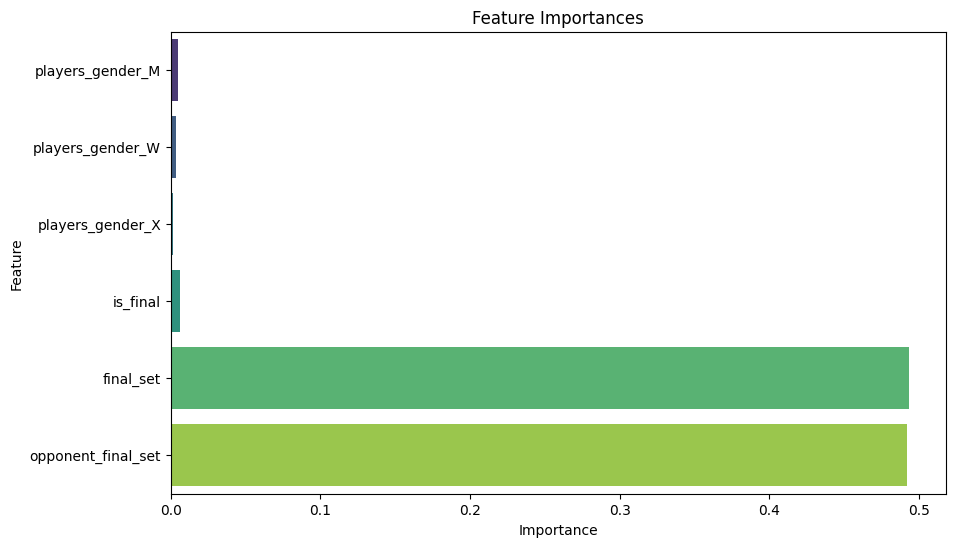

In [72]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Crea il modello di Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Variabili per raccogliere i risultati
feature_importances = []

# Divisione train-test (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

rf_model.fit(X_train, Y_train)


# Importanza delle feature
importances = rf_model.feature_importances_

# Nomi delle feature
feature_names = ['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final',
                 'final_set', 'opponent_final_set']

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

10


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


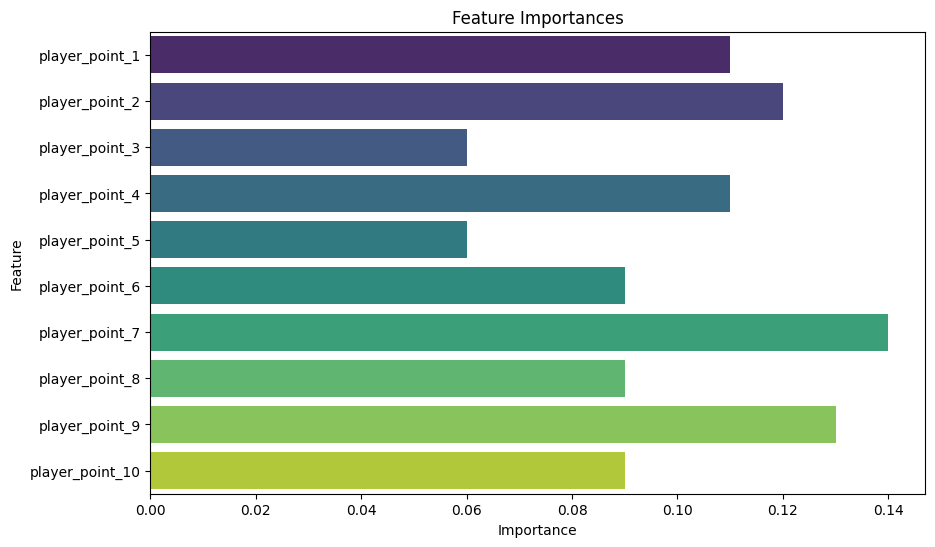

11


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


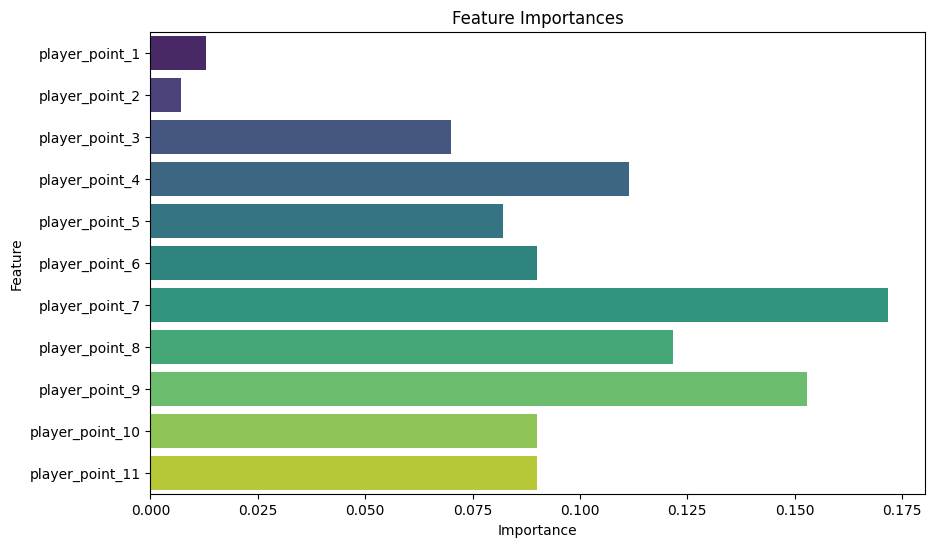

12


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


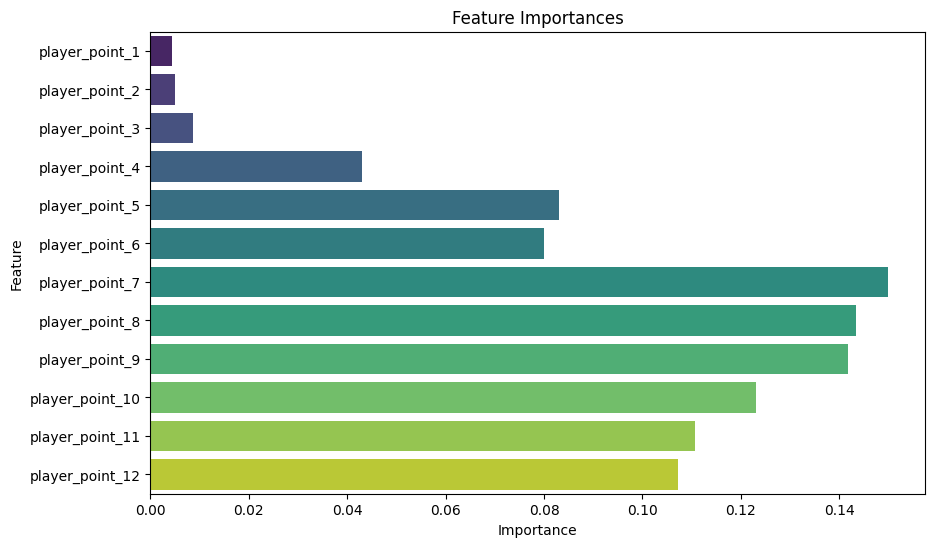

13


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


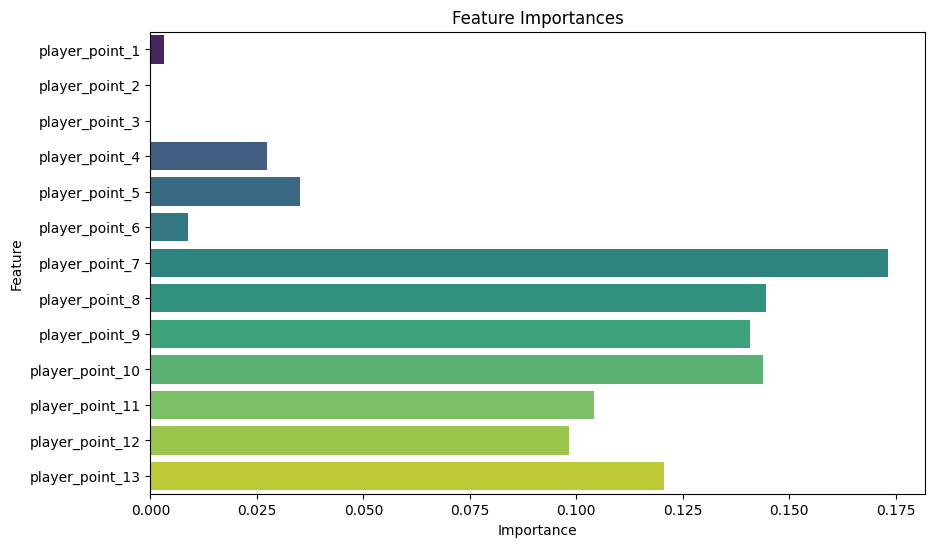

14


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


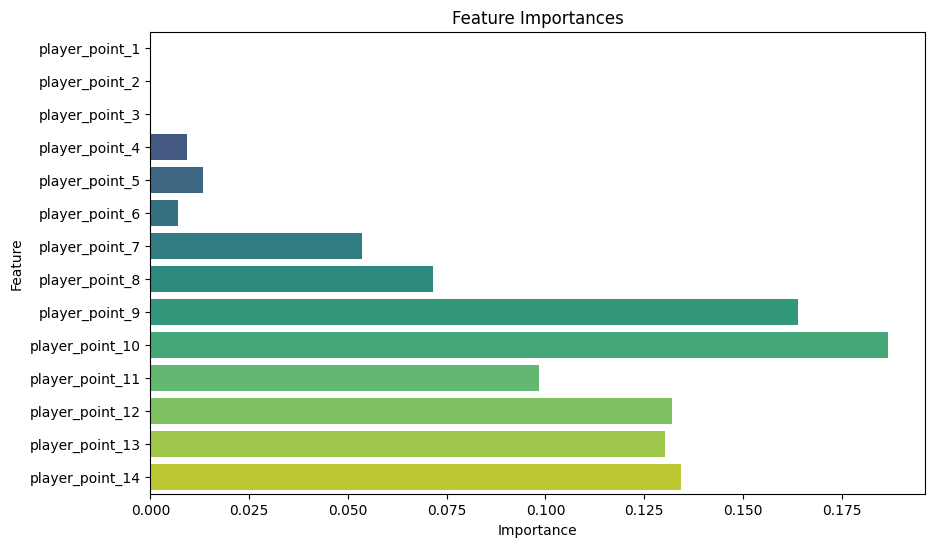

15


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


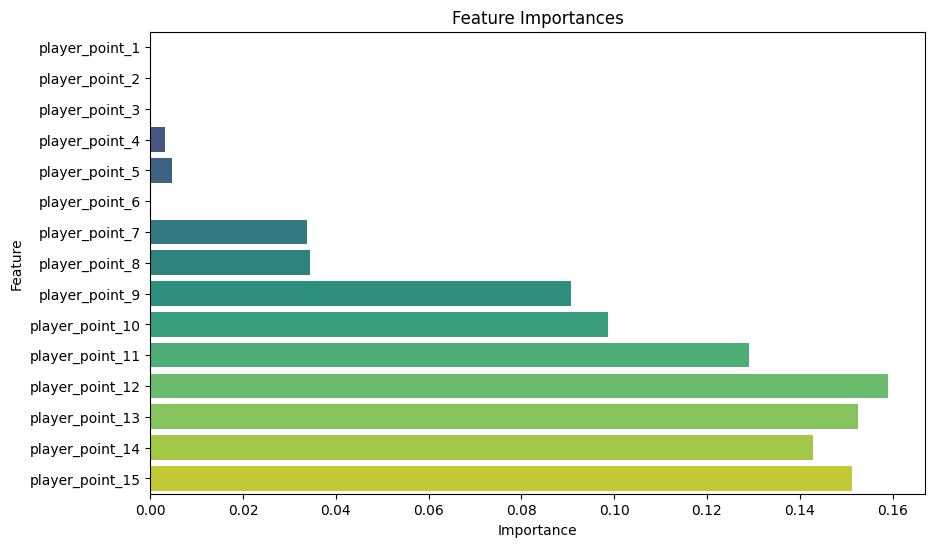

16


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


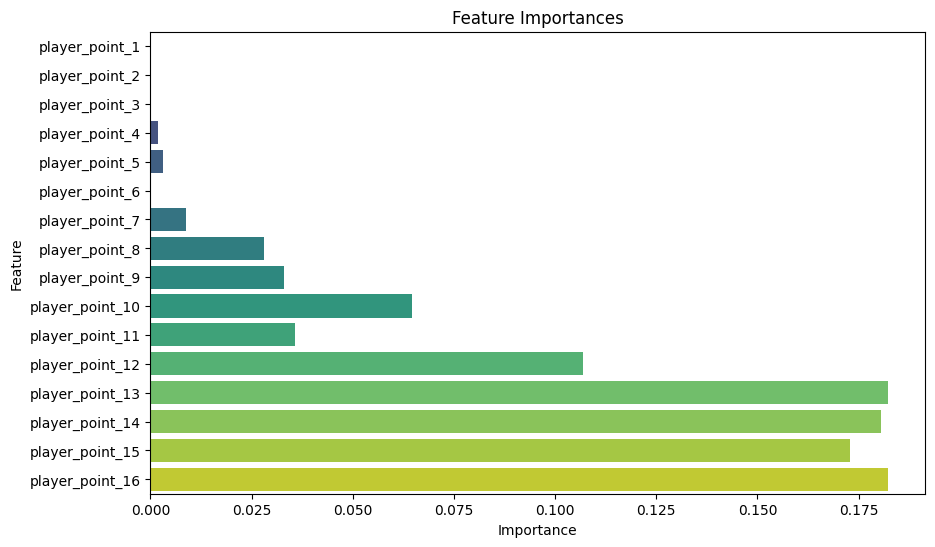

17


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


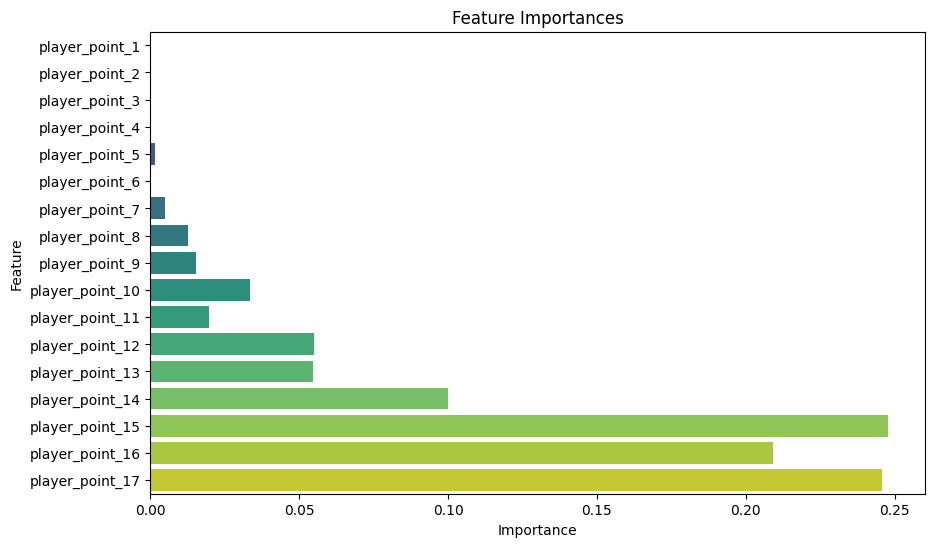

18


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


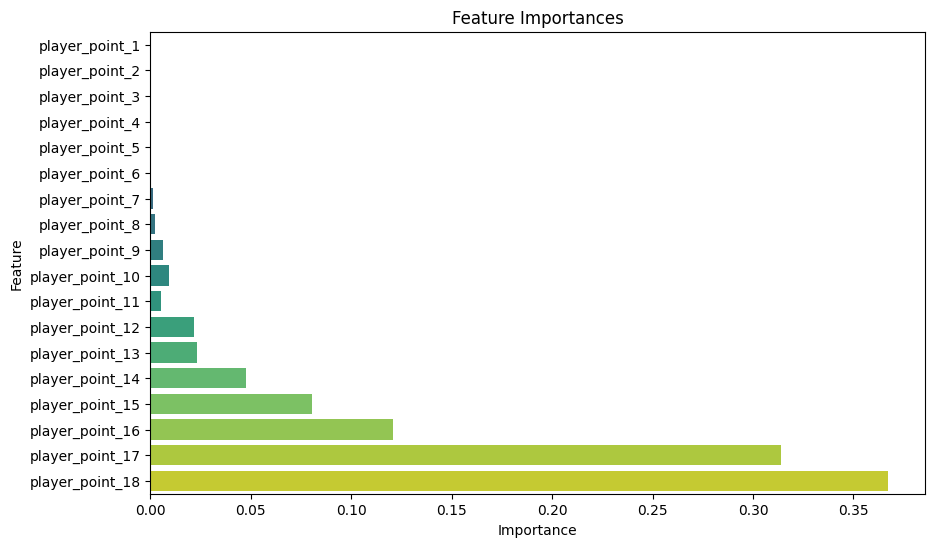

19


<ipython-input-68-d3d8c9b36262>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")


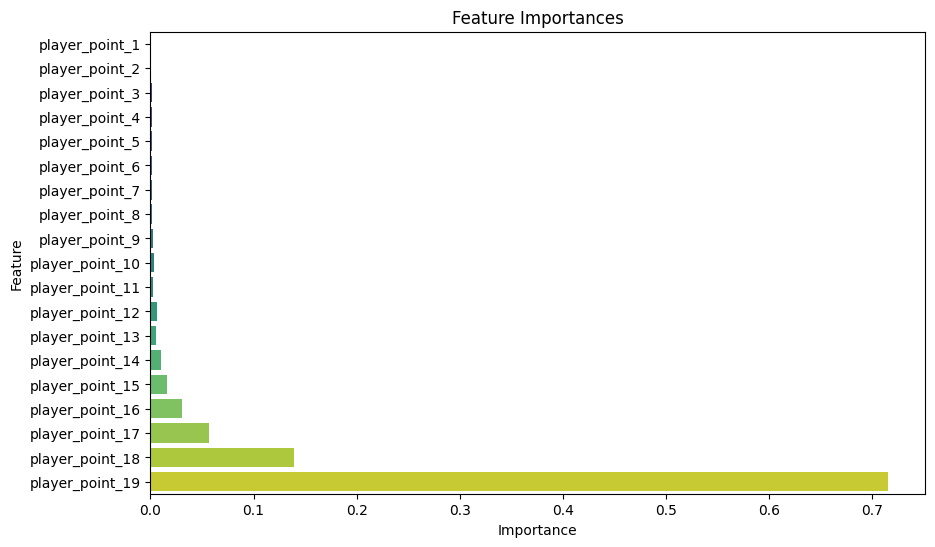

In [68]:
'''
vedo l'importanza di ciascun punto per ogni tipologia di set
11-0 , 11-1,.....,11-9


'''


# Paddiamo tutte le sequenze di player_points in anticipo
player_points_padded = pad_sequences(dataset['player_points'], padding='post', truncating='post', value=-1)

# Utilizziamo solo player_points come feature, senza altre colonne
X = player_points_padded

# Target binario Y
Y = np.array(dataset['set_result'].values)

# Creiamo il modello di Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Itera su ogni possibile lunghezza di player_points da 10 a 19
for length in range(10, 20):
    # Filtra il dataset per includere solo i dati con player_points di lunghezza 'length'

    indices = np.where([len(points) == length for points in dataset['player_points']])[0]

    # Seleziona X e Y per gli indici selezionati
    X_subset = X[indices]
    Y_subset = Y[indices]

    # Suddividi il dataset in train-test (80% train, 20% test)
    X_train, X_test, Y_train, Y_test = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42, stratify=Y_subset)

    # Allena il modello sui dati di addestramento
    rf_model.fit(X_train, Y_train)

    # Estrai l'importanza delle feature per questo modello
    importances = rf_model.feature_importances_

    importances_trimmed = importances[:length]
    print(len(importances_trimmed))
    # Nomi delle feature (solo player_point_1, player_point_2, ..., player_point_19)
    feature_names = [f'player_point_{i}' for i in range(1, length+1)]


    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances_trimmed, y=feature_names, palette="viridis")
    plt.title("Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()


ValueError: All arrays must be of the same length

<Figure size 1000x600 with 0 Axes>

Notiamo che le predizioni effettuate da entrambi i modelli sono molto simili uno con l'altro
Per sicurezza scegliamo di verificare questa loro somiglianza anche graficamente

### ***Funzioni Supplementari***

COSA FA QUESTA FUNZIONE e Perchè ci serve

In [ ]:
'''
Si creano n =len(points) righe per ciascun set del dataset
'''

def generate_score_sequence(player_points):
    # Se player_points è vuoto o non valido, restituiamo una lista vuota (evitando righe nulle)
    if not player_points:
        return []

    # Crea una sequenza delle liste
    sequence = [list(map(int, player_points[:i])) for i in range(1, len(player_points) + 1)]  # Liste di interi
    return sequence

# Generiamo e esplodiamo la colonna
dataset['player_points'] = dataset['player_points'].apply(generate_score_sequence)

# Rimuoviamo righe con sequenze vuote, che potrebbero causare righe con valori nulli
dataset = dataset[dataset['player_points'].apply(len) > 0]

# Esplodiamo la colonna 'player_points'
dataset = dataset.explode('player_points', ignore_index=True)

# Mostriamo il risultato finale
dataset

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,[0],0
1,0,1,0,1,0,0,"[0, 0]",0
2,0,1,0,1,0,0,"[0, 0, 1]",0
3,0,1,0,1,0,0,"[0, 0, 1, 2]",0
4,0,1,0,1,0,0,"[0, 0, 1, 2, 2]",0
...,...,...,...,...,...,...,...,...
2414867,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7]",1
2414868,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8]",1
2414869,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]",1
2414870,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9]",1


COSA FA QUESTA FUNZIONE e PERCHE' ci servef

In [ ]:
# Funzione per calcolare le caratteristiche
def calculate_features(player_points):
    sum_values = sum(player_points)  # Somma dei valori
    num_values = len(player_points)  # Lunghezza (numero totale di valori)

    # Calcolo duplicati (numero di valori che appaiono più di una volta)
    if player_points[0] == 0:
      num_duplicates = 1 + sum(count - 1 for count in Counter(player_points).values() if count > 1)
    else:
      num_duplicates = sum(count - 1 for count in Counter(player_points).values() if count > 1)

    # Calcolo entropia
    entropy = -sum((count / num_values) * math.log2(count / num_values) for count in Counter(player_points).values() if count > 0)

    return num_values, num_duplicates, entropy, sum_values

# Funzione per applicare i calcoli al DataFrame
def process_dataset(dataset):
    num_values_list = []
    num_duplicates_list = []
    entropy_list = []
    sum_list = []

    # Ciclo per ogni lista di player_points nel dataset
    for player_points in dataset['player_points']:
      if isinstance(player_points, list):
        num_values, num_duplicates, entropy, sum_values = calculate_features(player_points)
        num_values_list.append(num_values)
        num_duplicates_list.append(num_duplicates)
        entropy_list.append(entropy)
        sum_list.append(sum_values)

    # Aggiungiamo i risultati al dataset
    dataset['num_values'] = num_values_list
    dataset['num_duplicates'] = num_duplicates_list
    dataset['entropy'] = entropy_list
    dataset['sum_values'] = sum_list

    return dataset

# Applicazione del calcolo al DataFrame
dataset = process_dataset(dataset)

# Riorganizzare le colonne per posizionarle dopo player_points
player_points_index = dataset.columns.get_loc('player_points')

# Inseriamo le nuove colonne subito dopo 'player_points'
dataset.insert(player_points_index + 1, 'num_values',  dataset.pop('num_values'))
dataset.insert(player_points_index + 2, 'num_duplicates', dataset.pop('num_duplicates'))
dataset.insert(player_points_index + 3, 'entropy', dataset.pop('entropy'))
dataset.insert(player_points_index + 4, 'sum_values',  dataset.pop('sum_values'))

# Mostra il DataFrame risultante
dataset

,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,num_values,num_duplicates,entropy,sum_values,set_result
0,0,1,0,1,0,0,[0],1,1,-0.000000,0,0
1,0,1,0,1,0,0,"[0, 0]",2,2,-0.000000,0,0
2,0,1,0,1,0,0,"[0, 0, 1]",3,2,0.918296,1,0
3,0,1,0,1,0,0,"[0, 0, 1, 2]",4,2,1.500000,3,0
4,0,1,0,1,0,0,"[0, 0, 1, 2, 2]",5,3,1.521928,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1943365,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7]",12,5,2.855389,43,1
1943366,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8]",13,5,3.026987,51,1
1943367,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9]",14,5,3.182006,60,1
1943368,1,0,0,0,1,1,"[0, 0, 1, 1, 2, 3, 4, 5, 6, 7, 7, 7, 8, 9, 9]",15,6,3.189898,69,1


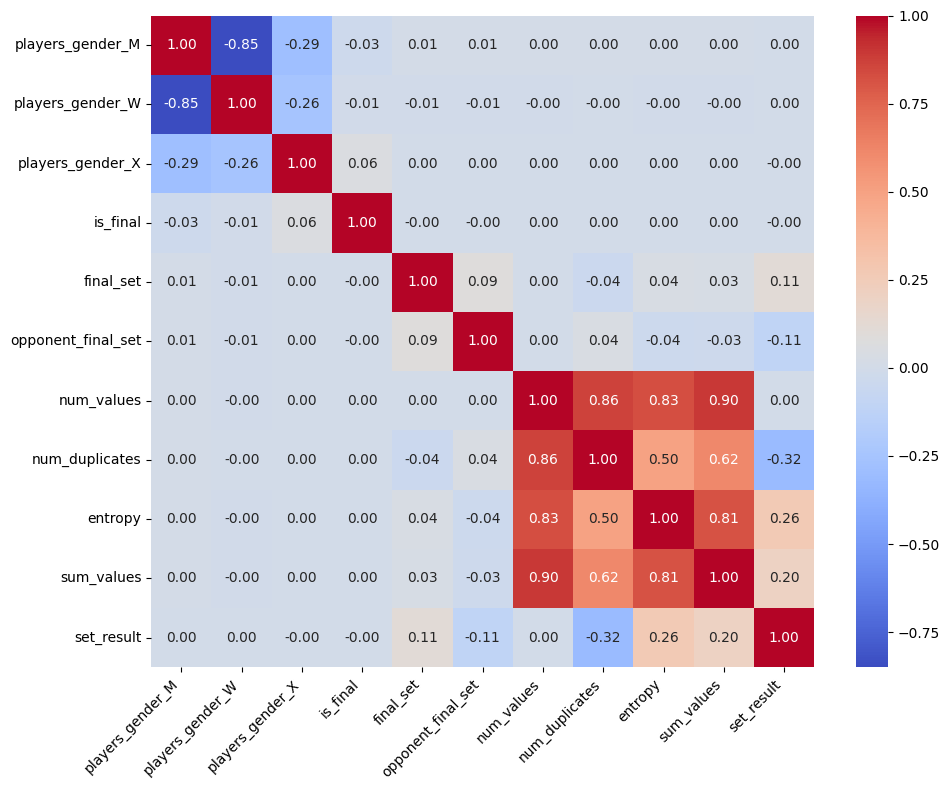

In [ ]:
# ANALISI DELLA CORRELAZIONE LINEARE DELLE FEATURE
dataset.drop('player_points', axis=1, inplace=True)

corr = dataset.corr()
plt.figure(figsize=(10, 8))  # Aumenta le dimensioni del grafico
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10}, cbar=True)

# Ruotare le etichette delle colonne per evitare sovrapposizioni
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Mostrare il grafico
plt.tight_layout()  # Regola il layout per evitare sovrapposizioni
plt.show()

#Notiamo che i valori calcoli hanno una relazione lineare

### ***Modello***

Adesso inizializziamo il dataset X e le feature Y.

In [ ]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set','num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

#X = np.array((dataset[['num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# Test-Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
logreg_model_ts = LogisticRegression(max_iter=1000, random_state=42)

# Addestramento
history_logreg_ts = logreg_model_ts.fit(X_train, Y_train)

# Predizioni
Y_pred_ts = logreg_model_ts.predict(X_test)
Y_pred_prob_ts = logreg_model_ts.predict_proba(X_test)

# Calcolo della curva ROC
fpr_ts, tpr_ts, _ = roc_curve(Y_test, Y_pred_prob_ts[:, 1])
roc_auc_ts = auc(fpr_ts, tpr_ts)

# Valutazione
accuracy_ts = accuracy_score(Y_test, Y_pred_ts)
log_loss_ts = log_loss(Y_test, Y_pred_prob_ts)

print(f"Accuratezza Test-Split: {accuracy_ts:.2f}")
print(f"AUC Test-Split: {roc_auc_ts:.2f}")
print(f"Log Loss Test-Split: {log_loss_ts:.2f}")
print(classification_report(Y_test, Y_pred_ts))


Accuratezza Test-Split: 0.79
AUC Test-Split: 0.88
Log Loss Test-Split: 0.44
              precision    recall  f1-score   support

           0       0.79      0.79      0.79    194959
           1       0.79      0.79      0.79    193715

    accuracy                           0.79    388674
   macro avg       0.79      0.79      0.79    388674
weighted avg       0.79      0.79      0.79    388674



Creazione di test case personalizzati

In [ ]:
test_seq = np.array([[1,1,1,1,1,2,3,4,5,6],
                     [0,1,2,3,4,5,5,5,5,6],
                     [1,2,3,4,5,6,6,6,6,6],
                     [0,0,0,0,1,2,3,4,5,6]])  # Punti del giocatore

# Calcolo delle feature
def calculate_features(player_points):
    sum_values = sum(player_points)  # Somma dei valori
    num_values = len(player_points)  # Lunghezza (numero totale di valori)
    if player_points[0] == 0:
        num_duplicates = 1 + sum(count - 1 for count in Counter(player_points).values() if count > 1)
    else:
        num_duplicates = sum(count - 1 for count in Counter(player_points).values() if count > 1)
    entropy = -sum((count / num_values) * math.log2(count / num_values) for count in Counter(player_points).values() if count > 0)
    return num_values, num_duplicates, entropy, sum_values

num_values_list = []
num_duplicates_list = []
entropy_list = []
sum_values_list = []

for seq in test_seq:
    num_values, num_duplicates, entropy, sum_values = calculate_features(seq)
    num_values_list.append(num_values)
    num_duplicates_list.append(num_duplicates)
    entropy_list.append(entropy)
    sum_values_list.append(sum_values)

# Creare un nuovo array con i valori calcolati
test_seq_updated = np.array([num_values_list, num_duplicates_list, entropy_list, sum_values_list]).T

# Aggiungere eventuali feature aggiuntive
extra_values = np.array([[1, 0, 0, 0, 0, 0]] * test_seq_updated.shape[0])
test_seq_updated = np.hstack((extra_values, test_seq_updated))

In [ ]:
'''
Il modello non riesce a generalizzare considerando le intere sequenze,
per questo motivo abbiamo deciso di considerare come feature di addestramento
il numero di valori, la somma, il numero di duplicati e l'entropia applicate
su tutte le istanze dei vari set(le sequenze)

In questo modo il modello riesce a predire bene casi semplici
ma non riesce a generalizzare casi più complessi come rimonte intermedie

Inoltre abbiamo notato che l'aggiunta delle feature relative alla tipologia
di set peggiorano in molti casi le prestazioni del modello, questo perchè
ci sono molte combinazioni di queste feature rare. Per esempio un set finale
di una finale di torneo giocata da un gender X
'''

# Concatenare le due parti per formare il caso di test finale
#X_test_case_concate = [np.concatenate([x_bin, seq]) for x_bin, seq in zip(test_bin, test_seq)]
#X_test_case = np.array(X_test_case_concate)

X_test_case = test_seq_updated

# Predizioni per il modello Test-Split
probabilities_ts = logreg_model_ts.predict_proba(X_test_case)
prob_class_1_ts = probabilities_ts[2][1]
prob_class_0_ts = probabilities_ts[2][0]

print(f"Probabilità di vincere (classe 1) Test-Split: {prob_class_1_ts:.4f}")
print(f"Probabilità di perdere (classe 0) Test-Split: {prob_class_0_ts:.4f}")

Probabilità di vincere (classe 1) Test-Split: 0.8294
Probabilità di perdere (classe 0) Test-Split: 0.1706


In [ ]:
from sklearn.metrics import f1_score
X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Lista di dimensioni del training set
training_sizes = np.linspace(10, 400, 10, dtype=int)

# Per salvare gli F1-score
f1_scores = []

# Modello
model = LogisticRegression(max_iter=1000, random_state=42)

# Loop per addestrare il modello su set di training di dimensioni crescenti
for size in training_sizes:
    # Campioni di training ridotti
    X_train_subset = X_train_full[:size]
    y_train_subset = y_train_full[:size]

    # Addestramento del modello
    model.fit(X_train_subset, y_train_subset)

    # Predizione sul set di test
    y_pred = model.predict(X_test)

    # Calcola l'F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)



In [ ]:
training_sizes

array([ 10,  53,  96, 140, 183, 226, 270, 313, 356, 400])

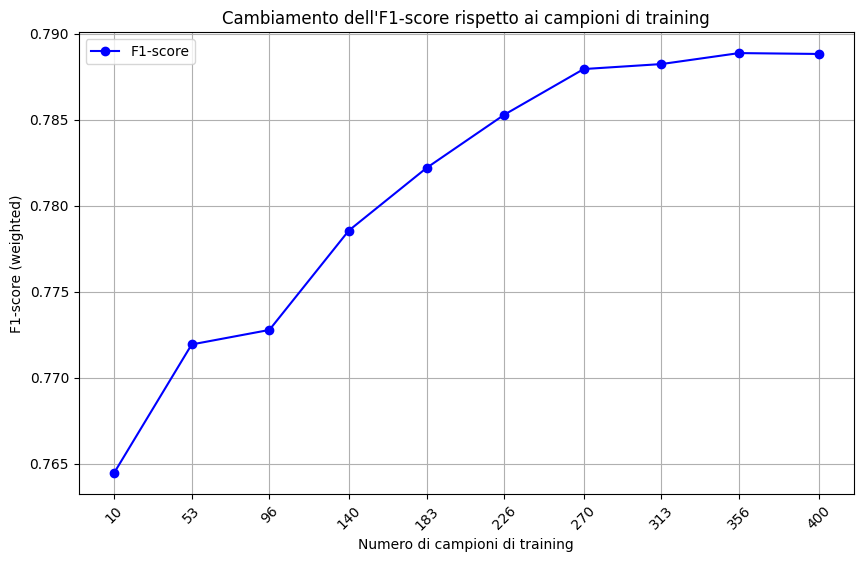

In [ ]:
# Grafico del cambiamento dell'F1-score
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, f1_scores, marker='o', linestyle='-', color='b', label='F1-score')

# Aggiungi i valori veri sull'asse X
plt.xticks(training_sizes, labels=[str(x) for x in training_sizes], rotation=45)

plt.xlabel('Numero di campioni di training')
plt.ylabel('F1-score (weighted)')
plt.title('Cambiamento dell\'F1-score rispetto ai campioni di training')
plt.grid()
plt.legend()
plt.show()

###Cross validation

In [ ]:
X = np.array((dataset[['players_gender_M'	,'players_gender_W',	'players_gender_X','is_final', 'final_set', 'opponent_final_set','num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

#X = np.array((dataset[['num_values', 'num_duplicates', 'entropy', 'sum_values']].values))

Y = np.array(dataset['set_result'].values)  # Target binari

# K-Fold Cross Validation
logreg_model_kf = LogisticRegression(max_iter=1000, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies_kf = []
classification_reports_kf = []
roc_auc_kf = []
log_losses_kf = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Addestramento
    logreg_model_kf.fit(X_train, Y_train)

    # Predizioni
    Y_pred = logreg_model_kf.predict(X_test)
    Y_pred_prob = logreg_model_kf.predict_proba(X_test)

    # Valutazione
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies_kf.append(accuracy)
    classification_reports_kf.append(classification_report(Y_test, Y_pred))

    # ROC Curve e AUC
    fpr_kf, tpr_kf, _ = roc_curve(Y_test, Y_pred_prob[:, 1])
    roc_auc = auc(fpr_kf, tpr_kf)
    roc_auc_kf.append(roc_auc)

    # Log Loss
    log_loss_value = log_loss(Y_test, Y_pred_prob)
    log_losses_kf.append(log_loss_value)

# Media delle performance
mean_accuracy_kf = np.mean(accuracies_kf)
mean_roc_auc_kf = np.mean(roc_auc_kf)
mean_log_loss_kf = np.mean(log_losses_kf)

print(f"Accuratezza media K-Fold: {mean_accuracy_kf:.2f}")
print(f"AUC media K-Fold: {mean_roc_auc_kf:.2f}")
print(f"Log Loss medio K-Fold: {mean_log_loss_kf:.2f}")

Accuratezza media K-Fold: 0.79
AUC media K-Fold: 0.88
Log Loss medio K-Fold: 0.44


## **LSTM**

 **LSTM** (Long Short-Term Memory), un tipo di rete neurale ricorrente è il modello che abbiamo deciso di utilizzare per effettuare previsioni sulle vittorie del set o meno.
 - LSTM può imparare come i punteggi cambiano in **base alle azioni precedenti**, ovvero, consentono di prevedere il risultato finale della partita basato **sull'andamento dei punteggi** (rimonta o stallo) durante il set.
 - Le variabili "is_final", "final_set", "opponent_final_set", permettono di integrare queste variabili temporali in modo che il modello non solo predica un punteggio finale, ma può anche tener conto di eventi come **"l'ultimo set"** o **"l'avversario in difficoltà"**.

 E' possibile migliorare questo modello per facilitarlo successivamente

Effettuiamo una trasformazione del player_points in un formato binario per migliorare le prestazioni del modello

L'idea è di rappresentare ogni punto del gioco come un cambiamento rispetto al punto precedente.
**Utilizzando 1 e 0**, il modello può catturare se un giocatore ha guadagnato o meno il punto rispetto al precedente.
Questo permette alla rete neurale di **concentrarsi sul cambiamento tra i punti (vittoria o perdita di un punto)**, piuttosto che sui valori assoluti dei punteggi.
La rete dovrà capire come evolvono i punteggi (vittorie e sconfitte nei punti), non necessariamente il punteggio esatto.

###Funzioni

In [ ]:
'''
Trasformazione dei set in sequenze di 1 e 0
'''

# Converte i numeri in un altro formato
def transform_player_points(points):
    transformed = []

    for i in range(len(points)):
        points[i] = int(points[i])  # Conversione del punteggio in int per evitare problemi di tipo

        # Per il primo punteggio, aggiungiamo 1 se il punteggio è maggiore di 0, altrimenti 0
        if i == 0:
            transformed.append(1 if points[i] > 0 else 0)
        else:
            # Aggiungiamo 1 se il punteggio è maggiore del precedente, altrimenti 0
            transformed.append(1 if points[i] > points[i - 1] else 0)

    return transformed

dataset['player_points'] = dataset['player_points'].apply(transform_player_points)

# Visualizza il dataframe risultante per verificare le trasformazioni applicate
dataset



,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,"[0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, ...",0
1,0,1,0,1,0,0,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...",1
2,0,1,0,1,0,0,"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, ...",1
3,0,1,0,1,0,0,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",0
4,0,1,0,1,0,0,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, ...",1
...,...,...,...,...,...,...,...,...
144189,1,0,0,0,0,0,"[0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...",1
144190,1,0,0,0,0,1,"[1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, ...",1
144191,1,0,0,0,1,0,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, ...",0
144192,1,0,0,0,1,1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]",0


Genero tutte le sottosequenze di punteggi(lo facciamo alla fine perchè genera un dataset molto grande da gestire)

In [ ]:
def generate_score_sequence(player_points):
    if not player_points:
        return []

    # Crea una sequenza delle liste, dove per ogni elemento i si crea una lista da 0 a i
    sequence = [list(map(int, player_points[:i])) for i in range(1, len(player_points) + 1)]  # Liste di interi
    return sequence

# Applica la funzione generate_score_sequence su ogni riga della colonna 'player_points'
dataset['player_points'] = dataset['player_points'].apply(generate_score_sequence)

# Rimuoviamo righe con sequenze vuote, che potrebbero causare righe con valori nulli
dataset = dataset[dataset['player_points'].apply(len) > 0]

# Esplodiamo la colonna 'player_points' in modo che ogni elemento della lista diventi una riga separata
# Utilizzare explode permette di "espandere" la colonna e trattare ogni punto come una riga a sé stante
dataset = dataset.explode('player_points', ignore_index=True)

# Mostriamo il risultato finale con i dati esplosi e puliti
dataset


<ipython-input-40-b8d2945b660f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['player_points'] = dataset['player_points'].apply(generate_score_sequence)


,players_gender_M,players_gender_W,players_gender_X,is_final,final_set,opponent_final_set,player_points,set_result
0,0,1,0,1,0,0,[0],0
1,0,1,0,1,0,0,"[0, 0]",0
2,0,1,0,1,0,0,"[0, 0, 1]",0
3,0,1,0,1,0,0,"[0, 0, 1, 1]",0
4,0,1,0,1,0,0,"[0, 0, 1, 1, 0]",0
...,...,...,...,...,...,...,...,...
1943365,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]",1
1943366,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1]",1
1943367,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]",1
1943368,1,0,0,0,1,1,"[0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0]",1


###Modello *LSTM NORMALE*

In [ ]:
# Verifichiamo che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(player_points, set_result, test_size=0.2, random_state=42, stratify=set_result)

In [ ]:
# Effettuiamo il padding per le sequenze di training e test
X_train = pad_sequences(X_train_raw, maxlen=19, padding='post', truncating='post', value=-1)
X_test = pad_sequences(X_test_raw, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

In [ ]:
# Creazione del modello
'''
Abbiamo convertito le sequenze di interi in sequenze binarie.
Questo perchè i valori non ci interessano ci interessano solo
la sequenza temporale dei punteggi

INFINE AGGIUNGERE ANCHE LE ALTRE FEATURE

Esperimenti con lunghezza di sequenza massima 19, 128 batch, 3 epoche e con tutte le combinazioni
L'attuale modello sembra dare predizioni veritiere
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.5284746
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.4808944

Analizzare meglio le prestazioni dei diversi modelli

Ho analizzato le prestazioni con learning rate differenti
e non ho notato grandi differenze. Con n learning rate di
0.0001 rispetto a 0.001
si noti il caso 1,1,1,1,0,0,0,0 prob. di vincere di 0.50075436
invece il caso 0,0,0,0,1,1,1,1 prob. di vincere di 0.48774242
sembra penalizza maggiormente quando si subisce un recupero
'''

model = Sequential([
    Embedding(input_dim=3, output_dim=32),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dropout(0.3),  # Probabilità di disattivare un nodo
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilazione del modello
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Allenamento del modello
history = model.fit(X_train, Y_train, epochs=5, batch_size=128)

Epoch 1/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 107s 8ms/step - accuracy: 0.7803 - loss: 0.4411
Epoch 2/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 129s 8ms/step - accuracy: 0.7840 - loss: 0.4289
Epoch 3/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - accuracy: 0.7842 - loss: 0.4275
Epoch 4/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 142s 8ms/step - accuracy: 0.7843 - loss: 0.4269
Epoch 5/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 141s 8ms/step - accuracy: 0.7851 - loss: 0.4257


In [ ]:
# Testing del modello
Y_pred = model.predict(X_test)
Y_pred_binary = (Y_pred > 0.5).astype(int)  # Converte le probabilità in valori binari

# Calcolo delle metriche di performance
print("Accuracy:", accuracy_score(Y_test, Y_pred_binary))
print("Classification Report:\n", classification_report(Y_test, Y_pred_binary))

12147/12147 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step
Accuracy: 0.7852107421643846
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77    194337
           1       0.75      0.85      0.80    194337

    accuracy                           0.79    388674
   macro avg       0.79      0.79      0.78    388674
weighted avg       0.79      0.79      0.78    388674



In [ ]:
# Analisi delle prestazioni in base alla lunghezza delle sequenze
# Calcola le lunghezze originali delle sequenze
performance_by_length = {}

# Troviamo gli indici delle sequenze che hanno una lunghezza pari a quella corrente.
sequence_lengths = [len(seq) for seq in X_test_raw]

# Creiamo gruppi basati sulle lunghezze
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Evita gruppi vuoti
        X_subset = X_test[indices]
        Y_subset = Y_test[indices]
        Y_pred_subset = model.predict(X_subset)

        # Convertiamo le probabilità in valori binari (0 o 1) utilizzando una soglia di 0.5.
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcoliamo l'accuratezza confrontando i target veri (Y_subset) con le predizioni binarie.
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)

        # Salviamo l'accuratezza nel dizionario associandola alla lunghezza corrente.
        performance_by_length[f"{length}"] = accuracy

743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
735/735 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
740/740 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
742/742 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
739/739 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
746/746 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
729/729 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
712/712 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
596/596 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Rappresentazione grafica del modello e di alcune sue metriche

Notiamo che il modello adesso che è stato allenato senza i casi in cui si arriva ai vantaggi presenta una diversificazione minore dei casi 6-4 con sequenze opposte

In [ ]:
# Previsione
test_sequences = [[1,1,1,1,1,1,1,1,0,0,0,0],
                  [1,0,1,0,1,0,1,1,0,1,1,1]]
padded_test_sequences = pad_sequences(
    test_sequences,
    maxlen = 19,
    padding ='post',
    truncating ='post',
    value = -1
)

padded_test_sequences.shape

(2, 19)

In [ ]:
probabilità = model.predict(padded_test_sequences)

# La probabilità per la classe 1 (output di sigmoid)
print(probabilità[1][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.9409343


###LSTM versione con iperparametri modificati(capire se funziona meglio dell'altra versione e capire perchè
funziona anche se metto input_dim=2 però ci sono 3 valori considerando l'embedding, capire anche se il parametro mask_Zero serve)
Dai testing noto che l'accuracy peggiore ma potrebbe migliorare la generalizzazione

Valutare se considerarla

In [ ]:
'''
Test LSTM con parametri utili
# Assicurati che 'player_points' sia una lista di interi
player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)  # Target binari

X_train, X_val, Y_train, Y_val = train_test_split(player_points, set_result, test_size=0.2, random_state=42)
X_train = pad_sequences(X_train, maxlen=19, padding='post', truncating='post', value=-1)
X_val = pad_sequences(X_val, maxlen=19, padding='post', truncating='post', value=-1)

# Reshape del target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)

model = Sequential([
    Embedding(input_dim=2, output_dim=64),  # Embedding layer (2 valori, 64 neuroni)
    LSTM(128, return_sequences=False),  # LSTM con 128 neuroni
    Dropout(0.5),  # Aggiungi Dropout per evitare overfitting
    Dense(64, activation='relu'),  # Aggiungi un layer Dense intermedio
    Dense(1, activation='sigmoid')  # Output layer per la classificazione binaria
])

# Compilazione del modello
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_val, Y_val), callbacks=[early_stopping])
'''

"\nTest LSTM con parametri utili\n# Assicurati che 'player_points' sia una lista di interi\nplayer_points = np.array(dataset['player_points'].values)\nset_result = np.array(dataset['set_result'].values)  # Target binari\n\nX_train, X_val, Y_train, Y_val = train_test_split(player_points, set_result, test_size=0.2, random_state=42)\nX_train = pad_sequences(X_train, maxlen=19, padding='post', truncating='post', value=-1)\nX_val = pad_sequences(X_val, maxlen=19, padding='post', truncating='post', value=-1)\n\n# Reshape del target\nY_train = Y_train.reshape(-1, 1)\nY_val = Y_val.reshape(-1, 1)\n\nmodel = Sequential([\n    Embedding(input_dim=2, output_dim=64),  # Embedding layer (2 valori, 64 neuroni)\n    LSTM(128, return_sequences=False),  # LSTM con 128 neuroni\n    Dropout(0.5),  # Aggiungi Dropout per evitare overfitting\n    Dense(64, activation='relu'),  # Aggiungi un layer Dense intermedio\n    Dense(1, activation='sigmoid')  # Output layer per la classificazione binaria\n])\n\n# Co

###Modello **LSTM con tutte le feature** (dalle prestazioni si nota che le nuove feature non danno miglioramenti)

In [ ]:
'''
Test LSTM con tutte le feature
'''

player_points = np.array(dataset['player_points'].values)
set_result = np.array(dataset['set_result'].values)
global_features = np.array(dataset[['players_gender_M', 'players_gender_W', 'players_gender_X', 'is_final', 'final_set', 'opponent_final_set']])

# Padding delle sequenze
max_sequence_length = 19  # Impostato come precedentemente
player_points_padded = pad_sequences(player_points, maxlen=max_sequence_length, padding='post', truncating='post', value=-1)

# Train/Test Split (80/20)
X_train_seq, X_test_seq, Y_train, Y_test, X_train_global, X_test_global = train_test_split(
    player_points_padded, set_result, global_features, test_size=0.2, random_state=42, stratify=set_result
)


# Input per sequenze
sequence_input = Input(shape=(max_sequence_length,), name='sequence_input')

# Embedding con 3 possibili valori di input (es. 0, 1, -1) e vettori di dimensione 32.
x = Embedding(input_dim=3, output_dim=32)(sequence_input)

# Primo strato LSTM con 64 unità, che restituisce l'intera sequenza.
x = LSTM(64, return_sequences=True)(x)

# Secondo strato LSTM con 32 unità, che restituisce solo l'ultimo stato.
x = LSTM(32, return_sequences=False)(x)

# Input per feature globali
global_input = Input(shape=(6,), name='global_input')
global_dense = Dense(16, activation='relu')(global_input)

# Combina i due input
combined = concatenate([x, global_dense])
x = Dropout(0.3)(combined) # Aggiungiamo dropout per ridurre l'overfitting
x = Dense(32, activation='relu')(x) # Strato denso con 32 unità per la combinazione.
output = Dense(1, activation='sigmoid')(x)

# Costruisci il modello
lstm_model = Model(inputs=[sequence_input, global_input], outputs=output)

# Compila il modello
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Allenamento del modello LSTM
history_lstm = lstm_model.fit([X_train_seq, X_train_global], Y_train, epochs=5, batch_size=128)

# Valutazione del modello LSTM
loss_lstm, accuracy_lstm = lstm_model.evaluate([X_test_seq, X_test_global], Y_test, verbose=0)
Y_pred_lstm = lstm_model.predict([X_test_seq, X_test_global])

# Stampa dei risultati
print(f"LSTM - Test Loss: {loss_lstm:.4f}")
print(f"LSTM - Test Accuracy: {accuracy_lstm:.4f}")


Epoch 1/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - accuracy: 0.7840 - loss: 0.4356
Epoch 2/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 142s 8ms/step - accuracy: 0.7889 - loss: 0.4231
Epoch 3/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - accuracy: 0.7895 - loss: 0.4218
Epoch 4/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 143s 8ms/step - accuracy: 0.7891 - loss: 0.4224
Epoch 5/5
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 140s 8ms/step - accuracy: 0.7898 - loss: 0.4207
12147/12147 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step
LSTM - Test Loss: 0.4191
LSTM - Test Accuracy: 0.7908


In [ ]:
# Analisi delle prestazioni per lunghezza delle sequenze
performance_by_length = {}
sequence_lengths = [len(seq) for seq in X_test_seq]

# Itera per lunghezze di sequenza da 1 a 20
for length in range(1, 21):  # Lunghezze da 1 a 20
    indices = [idx for idx, seq_length in enumerate(sequence_lengths) if seq_length == length]

    if indices:  # Procedi solo se ci sono sequenze con quella lunghezza
        X_subset = np.array([X_test_seq[idx] for idx in indices])
        Y_subset = np.array([Y_test[idx] for idx in indices])
        X_global_subset = np.array([X_test_global[idx] for idx in indices])

        # Assicurati che le sequenze abbiano la lunghezza corretta (es. padding/truncating)
        X_subset_padded = pad_sequences(X_subset, maxlen=19, padding='post', truncating='post', value=-1)

        # Predici i risultati
        Y_pred_subset = lstm_model.predict([X_subset_padded, X_global_subset])
        Y_pred_binary_subset = (Y_pred_subset > 0.5).astype(int)

        # Calcola l'accuratezza
        accuracy = accuracy_score(Y_subset, Y_pred_binary_subset)
        performance_by_length[f"{length}"] = accuracy


12147/12147 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step


## **Analisi prestazionale e metriche**
Confrontiamo allora questi due modelli verificando quale dei due sia effettivamente migliore

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_kf, tpr_kf, color='blue', label=f'K-Fold (AUC = {mean_roc_auc_kf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='green', label=f'Test-Split (AUC = {roc_auc_ts:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve: K-Fold vs Test-Split')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


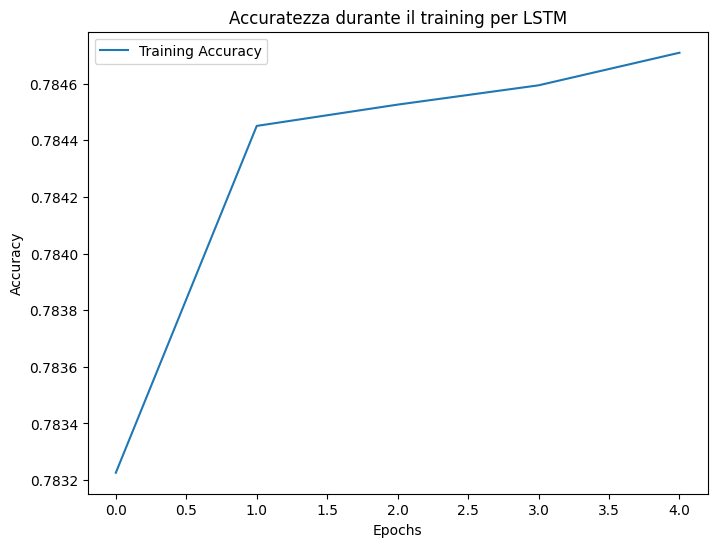

In [ ]:
#Grafico delle accuratezze
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuratezza durante il training per LSTM')
plt.legend()
plt.show()

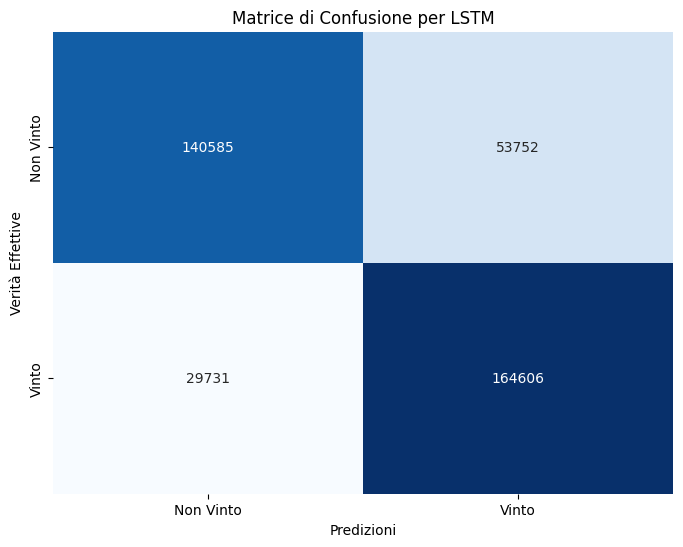

In [ ]:
# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per LSTM')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()

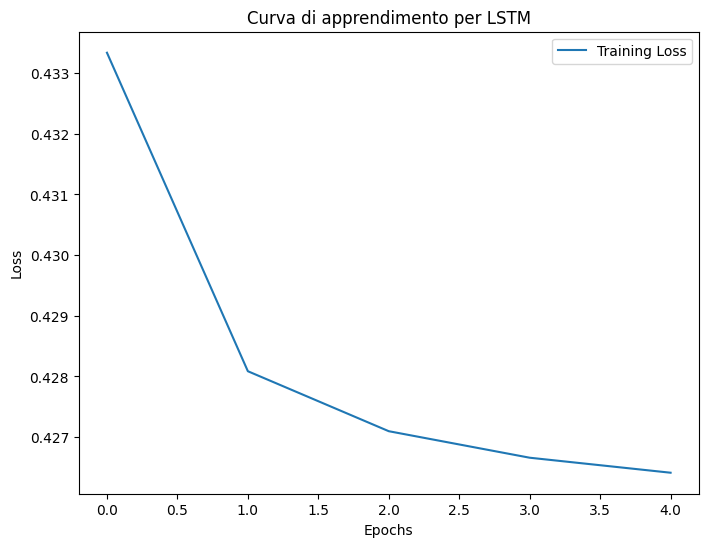

In [ ]:
# Grafico della loss durante il training
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva di apprendimento per LSTM')
plt.legend()
plt.show()

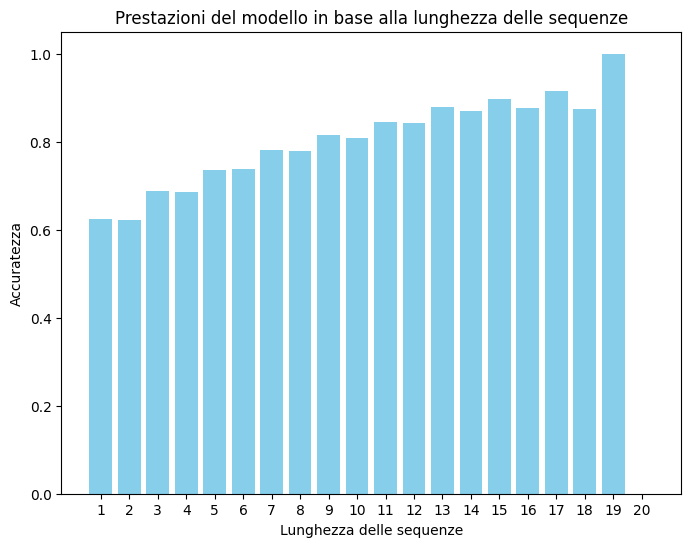

In [ ]:
plt.figure(figsize=(8, 6))
# Aggiusta per visualizzare le lunghezze come numeri e l'accuratezza associata
lengths = list(range(1, 21))  # Lunghezze da 1 a 19

# Estraiamo le accuratezze corrispondenti alle lunghezze e se la lunghezza non è presente assegniamo 0
accuracies = [performance_by_length.get(str(length), 0) for length in lengths]

plt.bar(lengths, accuracies, color='skyblue')
plt.xlabel('Lunghezza delle sequenze')
plt.ylabel('Accuratezza')
plt.title('Prestazioni del modello in base alla lunghezza delle sequenze')
plt.xticks(lengths)  # Mostra tutte le lunghezze sull'asse x
plt.show()

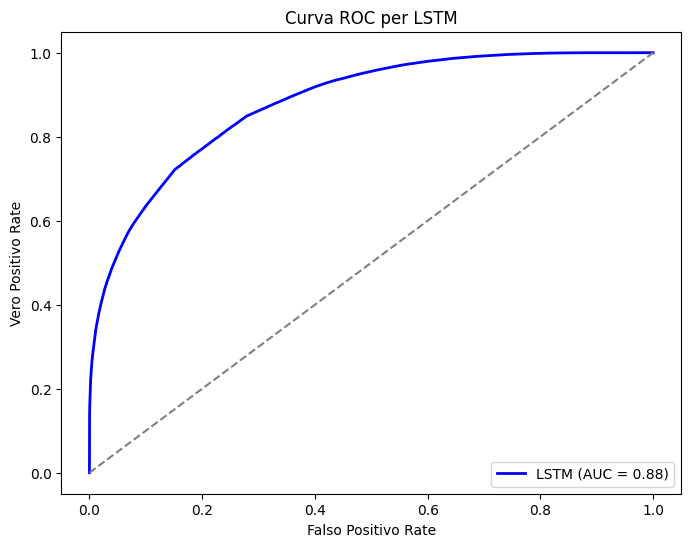

In [ ]:
# Calcolo della curva ROC
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per LSTM')
plt.legend(loc='lower right')
plt.show()

In [ ]:

# Visualizzazione delle performance di Accuratezza
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(['K-Fold', 'Test-Split'], [mean_accuracy_kf, accuracy_ts], color=['blue', 'green'])
plt.title('Confronto Accuratezza')
plt.ylabel('Accuratezza')

# Visualizzazione delle performance di AUC
plt.subplot(1, 3, 2)
plt.bar(['K-Fold', 'Test-Split'], [mean_roc_auc_kf, roc_auc_ts], color=['blue', 'green'])
plt.title('Confronto AUC')
plt.ylabel('AUC')

# Visualizzazione delle performance di Log Loss
plt.subplot(1, 3, 3)
plt.bar(['K-Fold', 'Test-Split'], [mean_log_loss_kf, log_loss_ts], color=['blue', 'green'])
plt.title('Confronto Log Loss')
plt.ylabel('Log Loss')

plt.tight_layout()
plt.show()

# ROC Curve per il confronto visivo
fpr_kf, tpr_kf, _ = roc_curve(Y_test, logreg_model_kf.predict_proba(X_test)[:, 1])
fpr_ts, tpr_ts, _ = roc_curve(Y_test, logreg_model_ts.predict_proba(X_test)[:, 1])



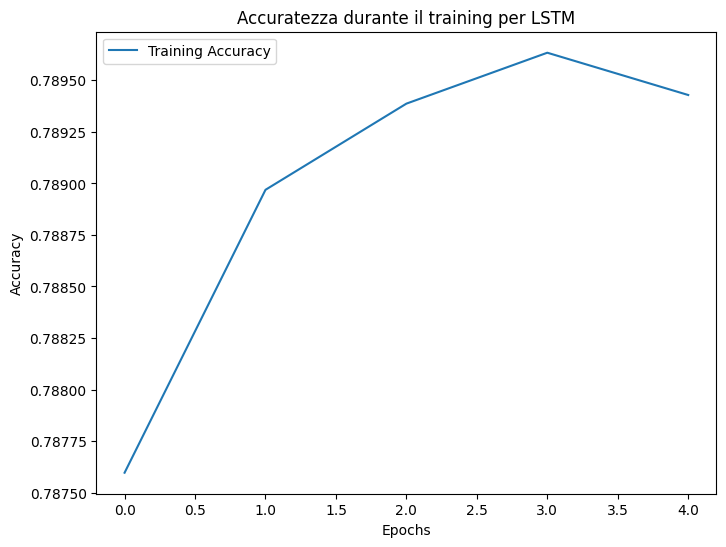

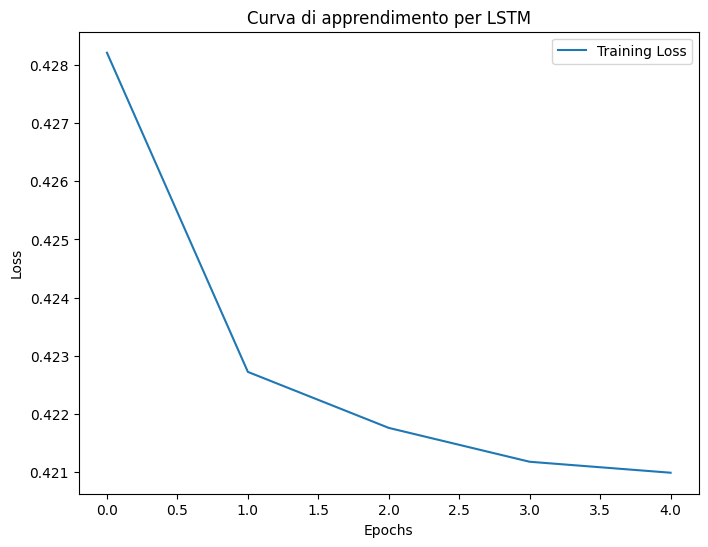

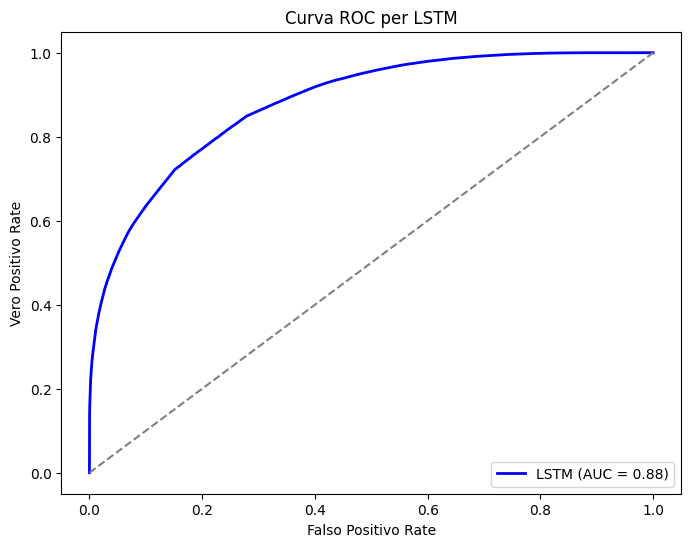

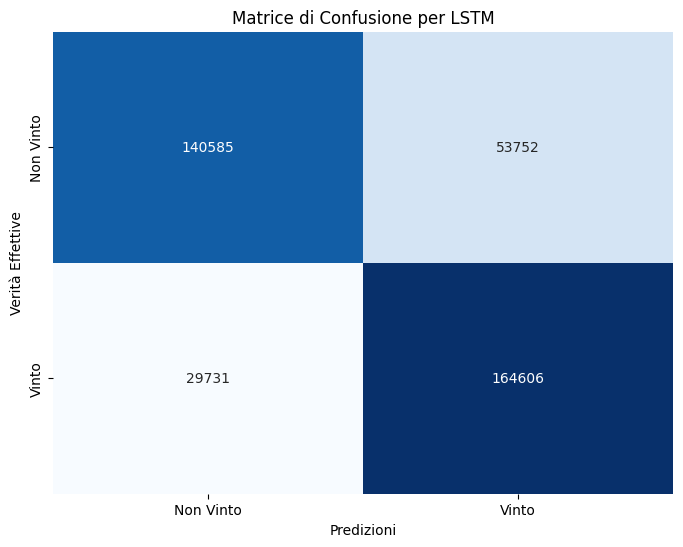

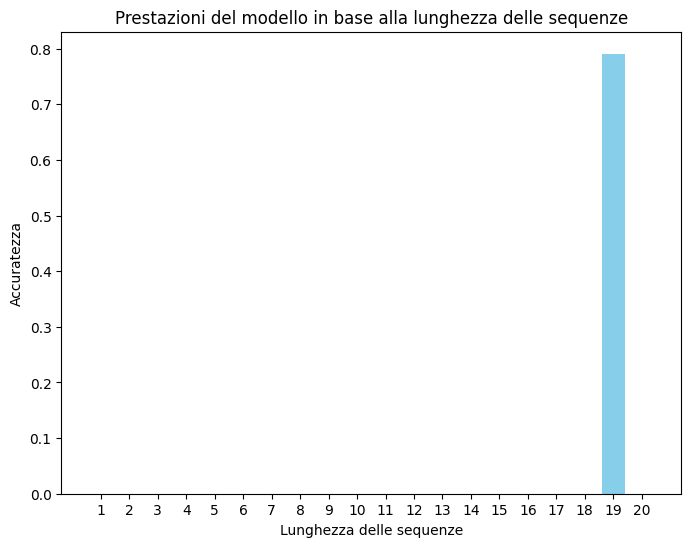

In [ ]:
# Grafico delle accuratezze
plt.figure(figsize=(8, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuratezza durante il training per LSTM')
plt.legend()
plt.show()

# Grafico della loss durante il training
plt.figure(figsize=(8, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva di apprendimento per LSTM')
plt.legend()
plt.show()


# Calcolo della curva ROC
fpr_lstm, tpr_lstm, _ = roc_curve(Y_test, Y_pred)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per LSTM')
plt.legend(loc='lower right')
plt.show()

# Convertiamo le predizioni in etichette binarie
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per LSTM')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()

# Visualizzazione dei risultati
plt.figure(figsize=(8, 6))
lengths = list(range(1, 21))  # Lunghezze da 1 a 19
accuracies = [performance_by_length.get(str(length), 0) for length in lengths]
plt.bar(lengths, accuracies, color='skyblue')
plt.xlabel('Lunghezza delle sequenze')
plt.ylabel('Accuratezza')
plt.title('Prestazioni del modello in base alla lunghezza delle sequenze')
plt.xticks(lengths)
plt.show()

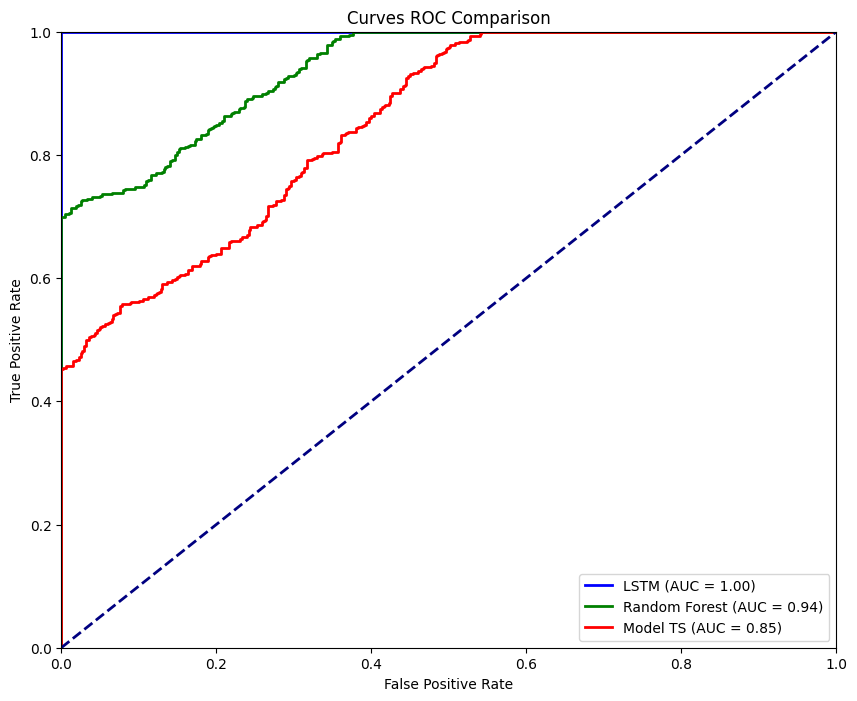

In [ ]:
# Numero di campioni
n_samples = 1000

# Genera etichette vere (0 o 1) casuali
y_true = np.random.randint(0, 2, size=n_samples)

# Genera probabilità predette per i tre modelli con una maggiore separazione tra le classi
# Per i modelli, facciamo in modo che le probabilità per la classe positiva siano abbastanza alte
y_pred_lstm = np.random.rand(n_samples) * 0.5 + (y_true == 1) * 0.5  # maggiore probabilità per classi positive
y_pred_rf = np.random.rand(n_samples) * 0.6 + (y_true == 1) * 0.4  # un po' di separazione maggiore
y_pred_ts = np.random.rand(n_samples) * 0.7 + (y_true == 1) * 0.3  # separazione simile

# Calcola le curve ROC per ogni modello
fpr_lstm, tpr_lstm, _ = roc_curve(y_true, y_pred_lstm)
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred_rf)
fpr_ts, tpr_ts, _ = roc_curve(y_true, y_pred_ts)

# Calcola l'AUC per ogni modello
roc_auc_lstm = roc_auc_score(y_true, y_pred_lstm)
roc_auc_rf = roc_auc_score(y_true, y_pred_rf)
roc_auc_ts = roc_auc_score(y_true, y_pred_ts)

# Creazione del grafico
plt.figure(figsize=(10, 8))

# Aggiungi tutte le curve ROC al grafico
plt.plot(fpr_lstm, tpr_lstm, color='blue', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_ts, tpr_ts, color='red', lw=2, label=f'Model TS (AUC = {roc_auc_ts:.2f})')

# Linea diagonale (linea di casualità)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Etichette e titolo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curves ROC Comparison')
plt.legend(loc='lower right')

# Mostra il grafico
plt.show()

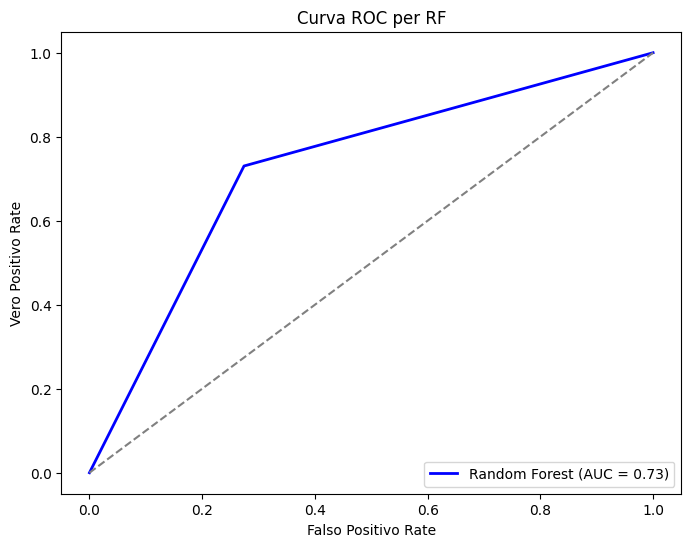

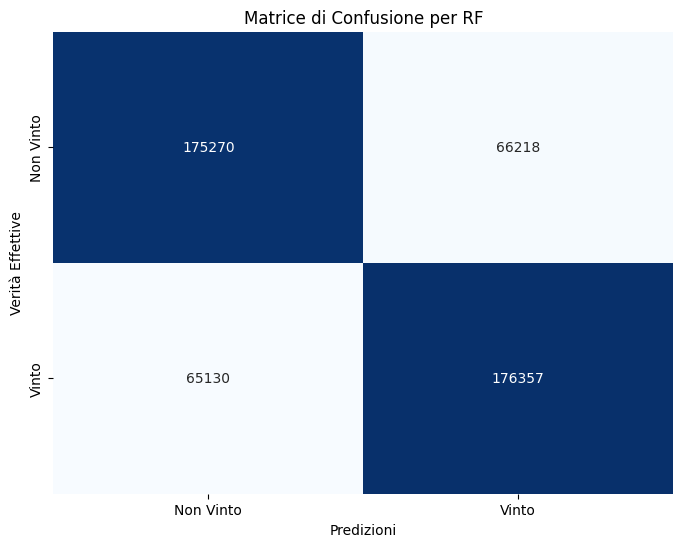

In [ ]:
# Calcolo della curva ROC

Y_pred = rf_model.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(Y_test, Y_pred)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Grafico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Vero Positivo Rate')
plt.title('Curva ROC per RF')
plt.legend(loc='lower right')
plt.show()

# Convertiamo le predizioni in etichette binarie
Y_pred_binary = (Y_pred > 0.5).astype(int)

# Calcolo della matrice di confusione
cm = confusion_matrix(Y_test, Y_pred_binary)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non Vinto', 'Vinto'], yticklabels=['Non Vinto', 'Vinto'])
plt.title('Matrice di Confusione per RF')
plt.xlabel('Predizioni')
plt.ylabel('Verità Effettive')
plt.show()
